In [1]:
# initialize environment for reproducibility

import torch
import random

random.seed(0)
torch.manual_seed(0)

In [2]:
# global variables

trainlistpath = "/home/liyy/data1/moco/datasets/.Fastmri_pics/trainlist.txt"
vallistpath = "/home/liyy/data1/moco/datasets/.Fastmri_pics/vallist.txt"
testlistpath = "/home/liyy/data1/moco/datasets/.Fastmri_pics/testlist.txt"

from datetime import datetime

timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')

expdir = f"./exp/{timestamp}/"
tensorboarddir = f"./.tb_logs/{timestamp}"

# mkdir

import os

os.makedirs(expdir, exist_ok=True)
os.makedirs(tensorboarddir, exist_ok=True)

print(f"expdir: {expdir}")
print(f"tensorboarddir: {tensorboarddir}")

epochs = 300
batch_size = 4

expdir: ./exp/20241128-010534/
tensorboarddir: ./.tb_logs/20241128-010534


In [3]:
# format: filename index_of_slice


with open(trainlistpath, 'r') as f:
    trainlist = f.readlines()
    trainlist = [(line.split()[0], int(line.split()[1])) for line in trainlist]

with open(vallistpath, 'r') as f:
    vallist = f.readlines()
    vallist = [(line.split()[0], int(line.split()[1])) for line in vallist]

with open(testlistpath, 'r') as f:
    testlist = f.readlines()
    testlist = [(line.split()[0], int(line.split()[1])) for line in testlist]

print("file in trainlist: ", len(trainlist))
print("file in vallist: ", len(vallist))
print("file in testlist: ", len(testlist))

file in trainlist:  12344
file in vallist:  3764
file in testlist:  1464


In [4]:
# dataset

import torch
from torchvision import transforms as tf
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

from models import mynn as mynn
from models.mynn import functional as myf

from random import shuffle

from einops import rearrange, repeat

from torchkbnufft import KbNufft, KbNufftAdjoint, calc_tensor_spmatrix, calc_density_compensation_function, ToepNufft

import numpy as np

import os


# ismrmrd_header rss csm kspace
class Fastmri_320p(Dataset):
    def __init__(self, filelist, num_subset = None, transform=None, lazy_memory=True, output_keys=["kspace", "after_transform"], output_type = dict, disk_cache = False):
        super(Fastmri_320p, self).__init__()
        self.filelist = filelist
        self.num_subset = num_subset
        self.transform = transform
        self.lazy_cache = lazy_memory
        self.output_keys = output_keys
        self.output_type = output_type
        self.disk_cache = disk_cache

        self.extension_disk_cache = "._cached"

        if self.num_subset is not None:
            self.filelist = self.filelist[:self.num_subset]

        self._cache = {}
        self._keys = ["kspace", "csm", "rss"]

        if not lazy_memory:
            try:
                for file in filelist:
                    path, index = file
                    if path not in self._cache:
                        self.load(path)
            except MemoryError as e: # The total size of the dataset is about 400GB
                print("Memory Error in preloading the dataset.", e)
                print("Lazy memory is recommended. Automatically switch to lazy memory.")
                self.release(ratio=0.75)
                self.lazy_cache = True

    def mnemonic_disk_cache(self, path):
        """
        Get the name of the disk cache file.
        """
        return path + self.extension_disk_cache

    def clean_disk_cache(self):
        """
        Clean the disk cache files.
        """
        print("WARNING: This will remove all disk cache files with the extension '._cached'.")
        for path, idx in self.filelist:
            cache_path = self.mnemonic_disk_cache(path)
            if os.path.exists(cache_path):
                os.remove(cache_path)

    def load(self, path):
        """
        Load the data from the file path.
        """
        cache_path = self.mnemonic_disk_cache(path)

        if self.disk_cache: # load from disk cache
            if os.path.exists(cache_path):
                self._cache[path] = torch.load(cache_path)
                return

        with np.load(path) as data:
            self._cache[path] = {key: torch.tensor(data[key]) for key in self._keys}
            self._cache[path].update(self.transform(self._cache[path]))
            for key in [key for key in self._cache[path] if key not in self.output_keys]:
                del self._cache[path][key]

            if self.disk_cache: # dump to disk cache
                torch.save(self._cache[path], cache_path)

    def release(self, ratio = 0.5):
        """
        Release the memory by deleting the cache with a ratio of the total cache.
        """
        assert 0 < ratio <= 1 , "The ratio must be a float between 0 and 1."

        keys_to_delete = shuffle(list(self._cache.keys()))[:int(len(self._cache) * ratio)]
        for key in keys_to_delete:
            del self._cache[key]

    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, idx):
        path, index = self.filelist[idx]

        if path not in self._cache:
            try:
                self.load(path)
            except MemoryError as e:
                self.release()
                self.load(path) # try again

        if self.output_type == dict:
            return {key: self._cache[path][key][index] for key in self.output_keys}
        elif self.output_type == list:
            return [self._cache[path][key][index] for key in self.output_keys]

In [5]:
# loadtransform
from torch import nn


load_keys = ['kspace']

class Loadtransform(nn.Module):
    """Load the data to the memory"""
    def __init__(self):
        super().__init__()

    def forward(self, data):
        # input: ismrmrd_header rss csm kspace
        return {'kspace': data['kspace'].to(torch.complex64)}


In [6]:
# data enhancement transform

import torch
from torch import nn
from torchvision import transforms as tf

from models.mynn import functional as myf
from torchkbnufft import KbNufft, KbNufftAdjoint, calc_tensor_spmatrix, calc_density_compensation_function, ToepNufft

from einops import rearrange, repeat


class Motion(nn.Module):
    def __init__(self, image_size = (320, 320),
                 motion_ratio = [1, 1, 1, 1, 1], rot = 15, shift = (0.05, 0.05), scale = (0.01, 0.01), shear = (0.01, 0.01),
                 num_spokes_full = 500, num_spokes_partial = 20, num_pts_readout = 320, oversampling_factor = 2,
                 dtype = torch.complex64, device = torch.device('cuda')):
        super().__init__()
        self.image_size = image_size
        self.rot = rot
        self.shift = shift
        self.scale = scale
        self.shear = shear
        self.num_spokes_full = num_spokes_full
        self.num_spokes_partial = num_spokes_partial
        self.num_pts_readout = num_pts_readout
        self.oversampling_factor = oversampling_factor
        self.dtype = dtype
        self.device = device

        self.float_dtype = torch.float32 if dtype == torch.complex64 else torch.float64

        self.num_motion_states = len(motion_ratio)
        self.motion_partition = [0]
        for ratio in motion_ratio:
            self.motion_partition.append(self.motion_partition[-1] + ratio / sum(motion_ratio))
        
        self.random_motion = tf.RandomAffine(degrees=rot, translate=shift, scale=scale, shear=shear, fill=0).to(device)
        self._nufft_obj = KbNufft(im_size=image_size, dtype=dtype, device=device)
        self._inufft_obj = KbNufftAdjoint(im_size=image_size, dtype=dtype, device=device)

        self.traj_full = self.gatraj().to(device).to(self.float_dtype)
        self.traj_partial = self.traj_full[:self.num_spokes_partial]

    def move(self, image):
        """ input: batch, channel, height, width
            output: motion_state, batch, channel, height, width
        """
        image = myf.complex_to_real(image) # batch, channel * 2, height, width
        resl = torch.zeros((self.num_motion_states+1), *image.shape, dtype=image.dtype, device=image.device) # motion_state batch, channel, height, width
        resl[0] = image
        for i in range(self.num_motion_states):
            resl[i+1] = self.random_motion(image)
        resl = myf.real_to_complex(resl) # motion_state, batch, channel, height, width
        return resl
    
    def gatraj(self):
        """Get golden angle trajectory"""
        import sys
        import os
        sys.path.append(os.path.join(os.environ['BART_TOOLBOX_PATH'], 'python'))
        from bart import bart
        traj = bart(1, f'traj -x {self.num_pts_readout} -y {self.num_spokes_full} -r -G -o {self.oversampling_factor}')
        traj = torch.tensor(traj)[:2, :, :].real
        traj = rearrange(traj, 'pos readout phase -> phase readout pos')
        return traj

    def ft(self, image, ktraj):
        ktraj_shape = ktraj.shape
        ktraj = ktraj / self.num_pts_readout * 2 * torch.pi # bart normalization to torchkbnufft normalization
        ktraj = rearrange(ktraj, 'phase readout pos -> pos (phase readout)')

        # batched nufft
        original_shape = image.shape
        image = rearrange(image, '... channel phase readout -> (...) channel phase readout') # nufft only accept [b h w] input

        res = torch.cat([self._nufft_obj(image[i].unsqueeze(0), ktraj) for i in range(image.shape[0])], dim = 0).view(*original_shape[:-2], ktraj_shape[0], ktraj_shape[1]) # ... phase readout
        return res
    
    def ift(self, kspace, ktraj):
        ktraj_shape = ktraj.shape
        ktraj = ktraj / self.num_pts_readout * 2 * torch.pi
        ktraj = rearrange(ktraj, 'phase readout pos -> pos (phase readout)')

        interp_mats = calc_tensor_spmatrix(ktraj,im_size=self.image_size, table_oversamp=2)
        dcomp = calc_density_compensation_function(ktraj=ktraj, im_size=self.image_size)

        # batched inufft
        original_shape = kspace.shape

        kspace = rearrange(kspace, '... channel phase readout -> (...) channel (phase readout)') # inufft only accept [b pts] input

        res = torch.cat([self._inufft_obj(kspace[i].unsqueeze(0) * dcomp, ktraj, interp_mats) for i in range(kspace.shape[0])], dim=0).view(*original_shape[:-2], *self.image_size) # ... height width
        return res

    def forward(self, image: torch.Tensor) -> torch.Tensor:
        image = self.move(image) # motion_state, batch, channel, height, width
        kspace = self.ft(image, self.traj_full) # motion_state, batch, channel, phase, readout

        indices = torch.randperm(kspace.shape[-2])
        kspace_mixed = torch.zeros_like(kspace[0]) # batch, channel, phase, readout
        for state in range(self.num_motion_states):
            kspace_mixed[:, :, indices[int(self.motion_partition[state] * indices.shape[0]):int(self.motion_partition[state+1] * indices.shape[0])], :] \
                = kspace[state][:, :, indices[int(self.motion_partition[state] * indices.shape[0]):int(self.motion_partition[state+1] * indices.shape[0])] , :]

        image = self.ift(kspace_mixed, self.traj_full)
        return image, kspace_mixed


class Dataenhance(nn.Module):
    """Computationally Intensive Transformations"""
    def __init__(self, motion_simulator: nn.Module):
        super().__init__()
        self.motion_simulator = motion_simulator

    def mean_std_norm_complex(self, data: torch.Tensor) -> torch.Tensor:
        real = data.real
        imag = data.imag
        real = (real - real.mean()) / real.std()
        imag = (imag - imag.mean()) / imag.std()
        return real + 1j * imag

    def forward(self, kspace):
        image = myf.ktoi(kspace)
        image = self.mean_std_norm_complex(image)
        kspace = myf.itok(image)
        image_after, kspace_after = self.motion_simulator(image)
        image_after = self.mean_std_norm_complex(image_after)
        return {"kspace_before":kspace, "kspace_after":kspace_after, "image_before":image, "image_after":image_after}






['ismrmrd_header', 'kspace', 'csm', 'rss']
torch.Size([16, 16, 320, 320])


/home/liyy/miniconda3/envs/moco/lib/python3.10/site-packages/torchkbnufft/_nufft/spmat.py:101: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/torch/csrc/utils/tensor_new.cpp:651.)
  torch.sparse.FloatTensor(inds, real_vals, torch.Size(shape)),  # type: ignore


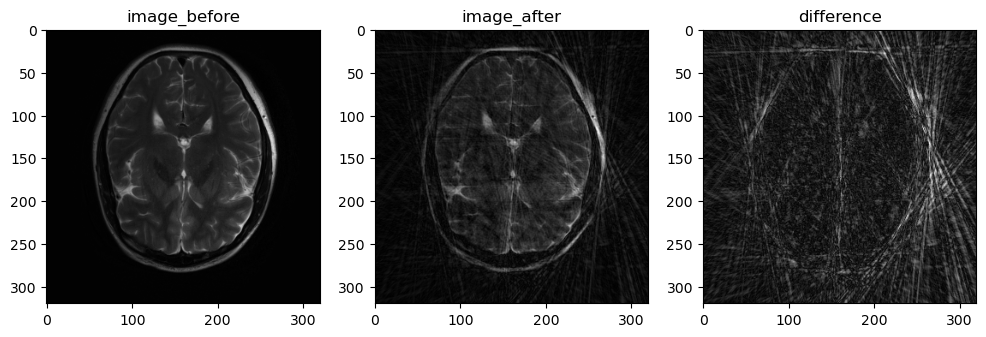

In [7]:
path = "/nas-data/datasets/FastMRI-brain/sorted/c16_size320_T2/traincrop320/file_brain_AXT2_200_6002508.crop320.npz"

import numpy as np
import torch

data = np.load(path)
print(list(data.keys()))
kspace = torch.tensor(data['kspace']).to(torch.complex64).to('cuda')
print(kspace.shape)

loadtransform = Loadtransform()
dataenhance = Dataenhance(Motion(device='cuda'))

with torch.no_grad():
    data = dataenhance(kspace)

    image_before = data['image_before'][0,0].to('cpu')
    image_after = data['image_after'][0,0].to('cpu')
    diff = torch.abs(image_before - image_after)
    
    from matplotlib import pyplot as plt

    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.imshow(torch.abs(image_before), cmap='gray')
    plt.title('image_before')
    plt.subplot(132)
    plt.imshow(torch.abs(image_after), cmap='gray')
    plt.title('image_after')
    plt.subplot(133)
    plt.imshow(diff, cmap='gray')
    plt.title('difference')

    plt.show()

In [8]:
# Model

from torch import nn
from torchvision import transforms as tf

from models import mynn as mynn


class AdaptedPad(nn.Module):
    """In order to modify Unet to be able to accept input from images of arbitrary size"""


    def __init__(self, depth : int, kernel_size : int = 2):
        """depth: Unet depth.
        n : nConv2d in one step."""
        super().__init__()
        self.depth = depth
        self.kernel_size = kernel_size

        self.prefix = {}

        for i in range(100):
            right = i
            left = i + 2 * kernel_size
            for _ in range(self.depth):
                left = left * 2  + 2 * kernel_size
                right = right * 2 - 2 * kernel_size
            if right <= 0:
                continue
            self.prefix[right] = left


    def __call__(self, image: torch.Tensor):
        shape = image.shape

        self.shape0 = [shape[-2], shape[-1]]
        shapen = torch.tensor(self.shape0)
        # backward_up
        for _ in range(self.depth):
            shapen = shapen + self.kernel_size * 2
            shapen = shapen // 2 + shapen % torch.tensor(2)

        # forward_up
        for _ in range(self.depth):
            shapen = shapen * 2
            shapen = shapen - self.kernel_size * 2
        shapen = torch.tensor([self.prefix[shapen[0].item()] , self.prefix[shapen[1].item()]])
        # # backward_down
        # for _ in range(self.d):
        #     shapen = shapen + self.n * 2
        #     shapen = shapen * 2

        # # backward_in
        # shapen = shapen + self.n * 2
        
        divshape = shapen - torch.tensor(self.shape0)
        # padding
        pad = tf.Pad([divshape[-1] // 2, divshape[-1] // 2 ,
                      divshape[-2] // 2, divshape[-2] // 2 ],
                      padding_mode='reflect')
        image = pad(image)
        return image
    

    def crop(self, image):
        crop = tf.CenterCrop(self.shape0)
        image = crop(image)
        return image


class AdaptedCrop(nn.Module):
    def __init__(self, n : int = 2):
        super().__init__()
        self.n = n


    def __call__(self, image: torch.Tensor, d : int):
        """depth: The number of times it's time to down."""
        if d == 0:
            return image
        shape = image.shape
        shapen = torch.tensor([shape[-2], shape[-1]])
        # down
        for _ in range(d):
            shapen = shapen // 2
            shapen = shapen - 2 * self.n

        # up
        shapen = shapen * 2
        for _ in range(d - 1):
            shapen = shapen - 2 * self.n
            shapen = shapen * 2
        crop = tf.CenterCrop((shapen[0].item(),shapen[1].item()))
        image = crop(image)
        return image


class Unet(nn.Module):

    def __init__(self, in_channels : int = 4 , out_channels : int = 4 , depth : int = 4, top_channels : int = 64, dtype = torch.float32, crop_res : bool = True) -> None:
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.depth = depth
        self.top_channels = top_channels
        self.dtype = dtype
        self.crop_res = crop_res
        self.padding = 0 if crop_res else 'same'

        if self.crop_res:
            self.pad = AdaptedPad(depth)
            self.crop = AdaptedCrop()
        self.checknan = mynn.CheckNan()
        self.checkinf = mynn.CheckInf()

        self._in = mynn.Boot(in_channels, top_channels, dtype = dtype,padding = self.padding) # in
        self.down_convs = nn.ModuleList() # Down convs
        channels = top_channels
        for _ in range(depth):
            self.down_convs.append(mynn.Down(channels, channels * 2, dtype = dtype, padding = self.padding))
            channels = channels * 2
        self.up_convs = nn.ModuleList() # Up convs
        for _ in range(depth):
            self.up_convs.append(mynn.Up(channels, channels // 2, dtype = dtype, padding = self.padding))
            channels = channels // 2
        self._out = mynn.Output(channels, out_channels, dtype = dtype, padding = self.padding)

    def forward(self, x: torch.Tensor):
        # double check
        x = self.checknan(x, 'in')
        x = self.checkinf(x, 'in')
        if self.crop_res:
            x = self.pad(x)
        x = self._in(x)
        if self.crop_res:
            cropped_x = self.crop(x, self.depth)
            res_x = [cropped_x]
        else:
            res_x = [x]
        # down path
        for i, f in enumerate(self.down_convs):
            x = f(x)
            if self.crop_res:
                cropped_x = self.crop(x,self.depth - 1 - i)
                res_x.append(cropped_x)
            else:
                res_x.append(x)
        # up path
        for i, f in enumerate(self.up_convs):
            x = f(x, res_x[-2 - i])
        if self.padding == 0:
            x = self.pad.crop(x)
        # out
        x = self._out(x)
        # double check
        x = self.checknan(x, 'out')
        x = self.checkinf(x, 'out')
        return x


In [9]:
from torch import nn

from models import mynn as mynn
from models.mynn import functional as myf

class MyModel(nn.Module):
    def __init__(self, in_channels : int = 16, out_channels : int = 16 , depth : int = 4, top_channels : int = 64, dtype = torch.float32, crop_res = True):
        super().__init__()
        self.unet_real = Unet(in_channels = in_channels, out_channels = out_channels, depth = depth, top_channels = top_channels, dtype = dtype, crop_res = crop_res)
        self.unet_imag = Unet(in_channels = in_channels, out_channels = out_channels, depth = depth, top_channels = top_channels, dtype = dtype, crop_res = crop_res)

    def forward(self, x: torch.Tensor):
        real = x.real
        imag = x.imag
        real = self.unet_real(real)
        imag = self.unet_imag(imag)
        return real + 1j * imag
        

In [10]:
# # train

# from torch import nn
# from torch import optim
# from torch.utils.data import DataLoader
# from torch.nn import functional as F

# from models import mynn as mynn
# from models.mynn import functional as myf

# import os

# from torch.utils.tensorboard import SummaryWriter

# writer = SummaryWriter(tensorboarddir)

# trainloader = DataLoader(Fastmri_320p(trainlist, transform = Loadtransform(), lazy_memory = True, output_keys = ['kspace'], output_type = dict, disk_cache = False), batch_size = batch_size, shuffle = True)
# valloader = DataLoader(Fastmri_320p(vallist, transform = Loadtransform(), lazy_memory = True, output_keys = ['kspace'], output_type = dict, disk_cache = False), batch_size = batch_size, shuffle = True)

# model = MyModel(in_channels = 16, out_channels = 16, depth = 4, top_channels = 64, dtype = torch.float32, crop_res = True).to(torch.device('cuda'))

# def loss_func(pred, target):
#     pred = myf.complex_to_real(pred)
#     target = myf.complex_to_real(target)
#     return F.mse_loss(pred, target)

# optimizer = optim.Adam(model.parameters(), lr = 1e-3)

# dataenhance = Dataenhance(Motion(device = torch.device('cuda')))

# iter_cnter = 0

# for epoch in range(epochs):
    
#     loss_epoch = 0
#     for i, data in enumerate(trainloader):
#         model.train()
#         kspace = data['kspace'].to('cuda')
#         with torch.no_grad():
#             data_after = dataenhance(kspace)
#         image_true = data_after['image_before'].to(torch.device('cuda'))
#         image_after = data_after['image_after'].to(torch.device('cuda'))

#         optimizer.zero_grad()
#         image_pred = model(image_after)
#         loss = loss_func(image_pred, image_true)
#         loss.backward()
#         optimizer.step()
#         print(f"epoch: {epoch}, batch: {i}, loss: {loss.item ()}")
#         loss_epoch += loss.item()

#         writer.add_scalar('Loss/train_iter', loss, iter_cnter)
#         iter_cnter += 1

#     writer.add_scalar('Loss/train', loss, epoch)

#     # if epoch % 10 == 0:
#     model.eval()
#     loss_epoch = 0
#     with torch.no_grad():
#         for i, data in enumerate(valloader):
#             kspace = data['kspace'].to('cuda')
#             with torch.no_grad():
#                 data_after = dataenhance(kspace)
#             image_true = data_after['image_before'].to(torch.device('cuda'))
#             image_after = data_after['image_after'].to(torch.device('cuda'))

#             image_pred = model(image_after)
#             loss = loss_func(image_pred, image_true)
#             loss_epoch += loss.item()
#             print(f"epoch: {epoch}, batch: {i}, loss: {loss.item ()}")

#     writer.add_scalar('Loss/val', loss, epoch)
#     torch.save(model.state_dict(), os.path.join(expdir, f"model_{epoch}.pth"))


/tmp/ipykernel_3528256/3333216318.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/home/liyy/data1/moco/exp/20241126-225143/model_iter

batch: 0, loss: 0.03499985486268997


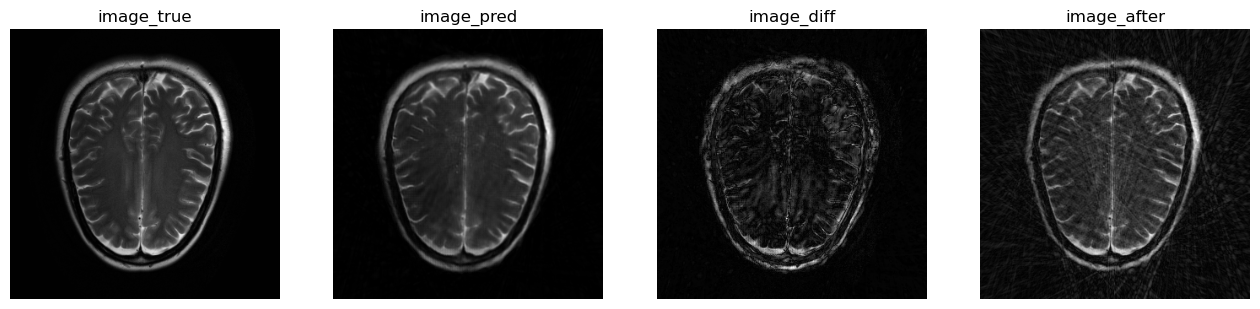

ssim: 0.9754155278205872
batch: 1, loss: 0.04565122351050377


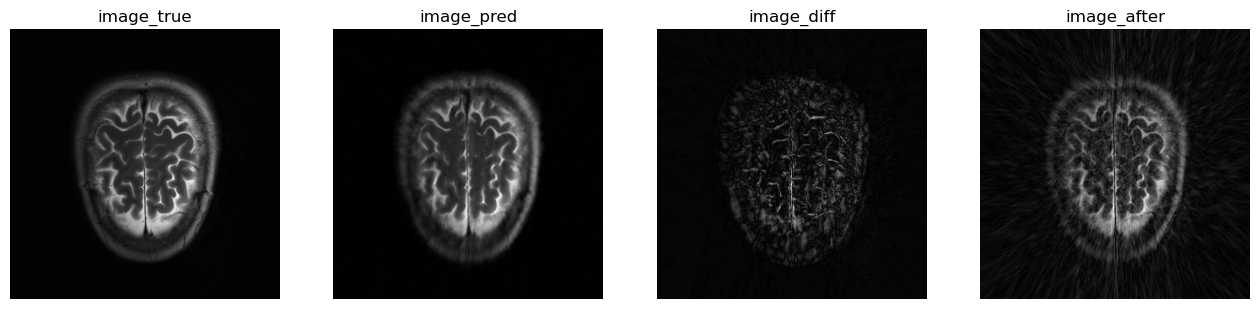

ssim: 0.941572904586792
batch: 2, loss: 0.0509873628616333


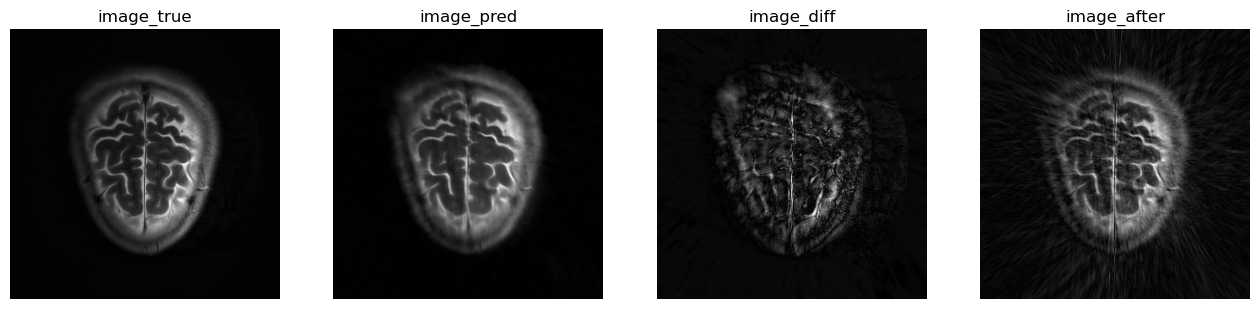

ssim: 0.9345403909683228
batch: 3, loss: 0.08817937970161438


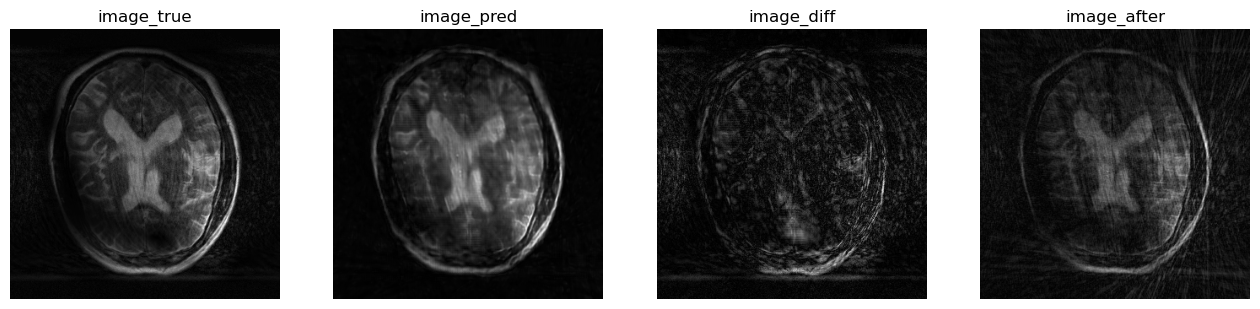

ssim: 0.9037074446678162
batch: 4, loss: 0.03861325979232788


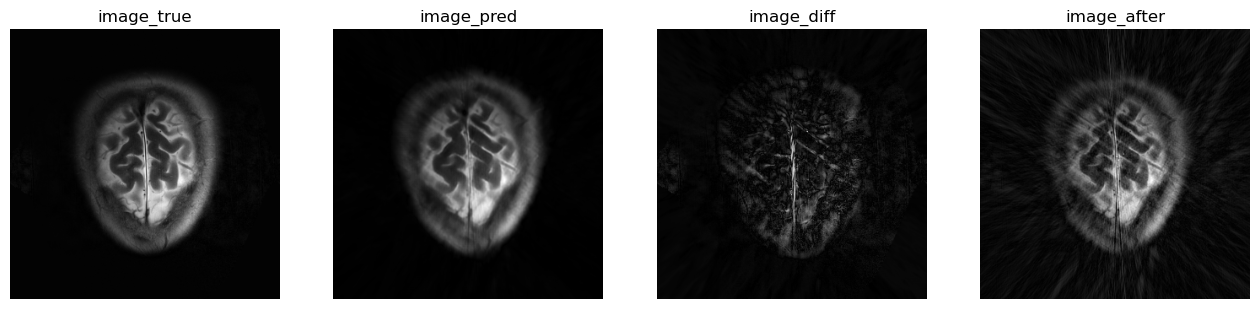

ssim: 0.9034848213195801
batch: 5, loss: 0.07568518817424774


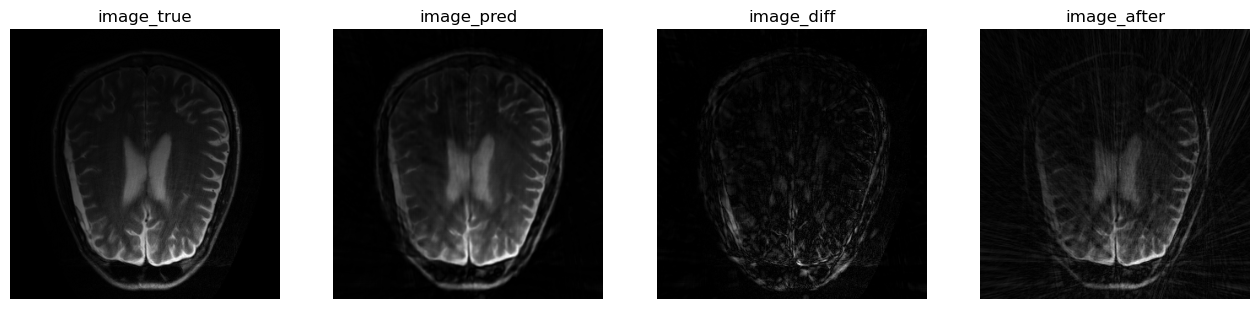

ssim: 0.927812933921814
batch: 6, loss: 0.05720112845301628


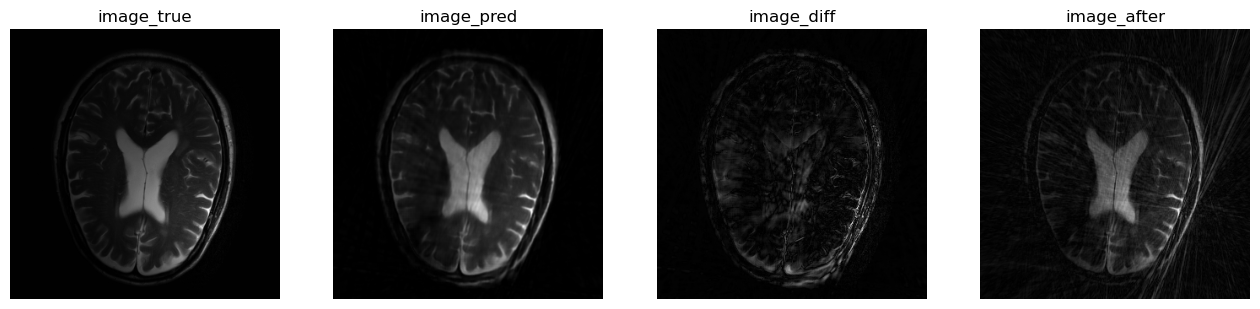

ssim: 0.9383702278137207


In [17]:
from email.mime import image
import torch
from torch.utils.data import DataLoader


def loss_func(pred, target):
    pred = myf.complex_to_real(pred)
    target = myf.complex_to_real(target)
    return F.mse_loss(pred, target)

model = MyModel(in_channels = 16, out_channels = 16, depth = 4, top_channels = 64, dtype = torch.float32, crop_res = True).to(torch.device('cuda'))

model.load_state_dict(torch.load("/home/liyy/data1/moco/exp/20241126-225143/model_iter_8000.pth"))


testloader = DataLoader(Fastmri_320p(vallist, transform = Loadtransform(), lazy_memory = True, output_keys = ['kspace'], output_type = dict, disk_cache = False), batch_size = 1, shuffle = True)

model.eval()

dataenhance = Dataenhance(Motion(device = torch.device('cuda')))

def mean_std_norm_complex(data: torch.Tensor) -> torch.Tensor:
    real = data.real
    imag = data.imag
    real = (real - real.mean()) / real.std()
    imag = (imag - imag.mean()) / imag.std()
    return real + 1j * imag


def mean_std_norm_real(data: torch.Tensor) -> torch.Tensor:
    return (data - data.mean()) / data.std()


# ssim
from skimage.metrics import structural_similarity as ssim

with torch.no_grad():
    for i, data in enumerate(testloader):
        kspace = data['kspace'].to('cuda')
        with torch.no_grad():
            data_after = dataenhance(kspace)
        image_true = data_after['image_before'].to(torch.device('cuda'))
        image_after = data_after['image_after'].to(torch.device('cuda'))

        image_pred = model(image_after)
        loss = loss_func(image_pred, image_true)
        print(f"batch: {i}, loss: {loss.item ()}")

        image_true = myf.complex_to_real(image_true)
        image_pred = myf.complex_to_real(image_pred)

        image_true = mean_std_norm_real(image_true)
        image_pred = mean_std_norm_real(image_pred)

        # print(image_true.shape, image_pred.shape)

        ssim_score = ssim(image_true[0].cpu().numpy(), image_pred[0].cpu().numpy(), channel_axis=0, data_range=(image_true.max() - image_true.min()).cpu().numpy())

        image_true_show = myf.real_to_complex(image_true).cpu().abs()
        image_after_show = mean_std_norm_complex(image_after).cpu().abs()
        image_pred_show = myf.real_to_complex(image_pred).cpu().abs()

        image_diff_show = (image_true_show - image_pred_show).abs()

        from matplotlib import pyplot as plt

        plt.figure(figsize=(16, 4))
        plt.subplot(141)
        plt.imshow(image_true_show[0,0], cmap='gray')
        plt.title('image_true')
        plt.axis('off')
        plt.subplot(142)
        plt.imshow(image_pred_show[0,0], cmap='gray')
        plt.title('image_pred')
        plt.axis('off')
        plt.subplot(143)
        plt.imshow(image_diff_show[0,0], cmap='gray')
        plt.title('image_diff')
        plt.axis('off')
        plt.subplot(144)
        plt.imshow(image_after_show[0,0], cmap='gray')
        plt.title('image_after')
        plt.axis('off')
        
        plt.show()

        print(f"ssim: {ssim_score}")

        

        if i > 5:
            break